# Create dataset

In [326]:
from PIL import Image
import glob
import os.path
import re

base_dir = 'c:/clustering/dataset/' # images are expected to be in subfolders of this folder (no nested subfolders)
resized_suffix = '_resized'

size = (240, 240)
images = []
labels = []
for filename in glob.glob(base_dir + '*/*.jpg'):
    if resized_suffix in filename: continue # make sure we don't process the files we already resized
    resized_filename = os.path.splitext(filename)[0] + resized_suffix + '.jpg'
    if not os.path.isfile(resized_filename):
        image = Image.open(filename)
        image.thumbnail(size, Image.ANTIALIAS)
        image.save(resized_filename, "JPEG")
    images.append(Image.open(resized_filename))
    labels.append(re.split("[/\\\]", filename)[-2])

print("prepared " + str(len(images)) + " images")

prepared 229 images


# Extract Features

In [383]:
import numpy as np
X = np.ones(shape=(len(images), 0)) # initialize feature matrix X
X.shape

(229, 0)

## HSV histogram

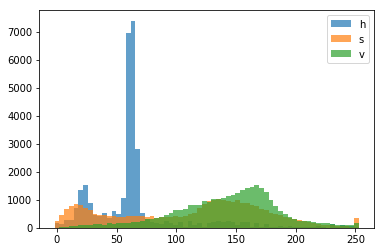

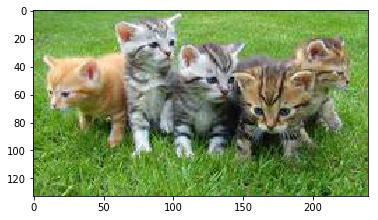

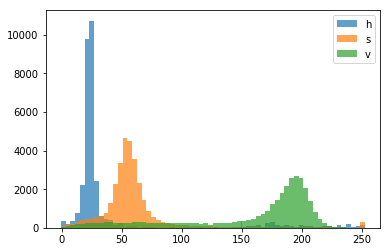

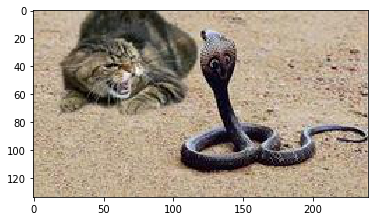

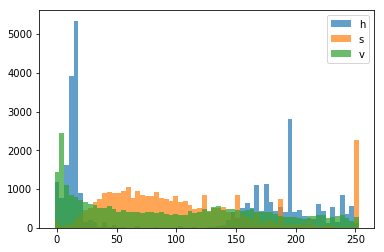

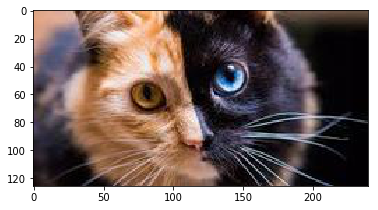

In [328]:
import matplotlib.pyplot as plt
%matplotlib inline

bins_per_channel = 64;
n_features = bins_per_channel * 3
features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

for i, image in enumerate(images):
    hsv = image.convert('HSV');
    h_hist, bins = np.histogram(hsv.getchannel('H'), bins=bins_per_channel)
    s_hist, bins = np.histogram(hsv.getchannel('S'), bins=bins_per_channel)
    v_hist, bins = np.histogram(hsv.getchannel('V'), bins=bins_per_channel)
    features[i] = np.concatenate([h_hist, s_hist, v_hist])
    if i < 3: 
        plt.figure()
        plt.bar(bins[:-1], h_hist, alpha=.7, label='h', width=255/bins_per_channel)
        plt.bar(bins[:-1], s_hist, alpha=.7, label='s', width=255/bins_per_channel)
        plt.bar(bins[:-1], v_hist, alpha=.7, label='v', width=255/bins_per_channel)
        plt.legend()
        plt.figure()
        plt.imshow(image)

X = np.column_stack((X, features)) # add new features to feature matrix X

### RGB Histogram

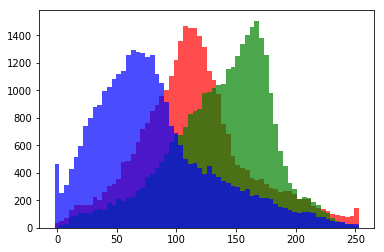

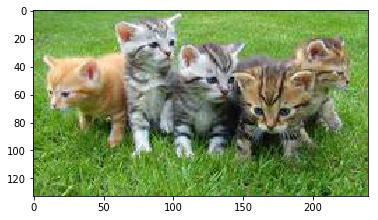

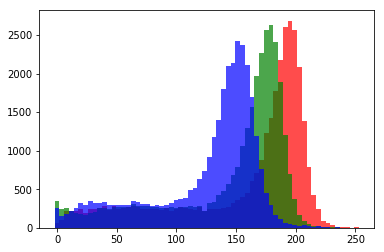

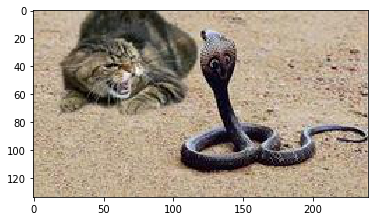

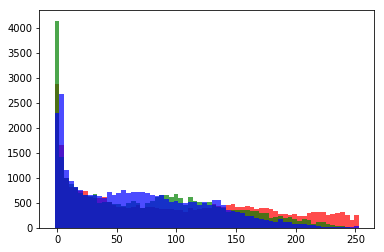

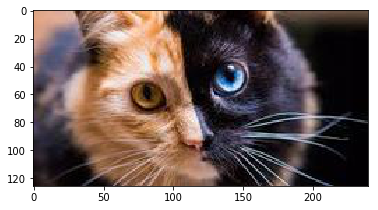

In [329]:
import matplotlib.pyplot as plt
%matplotlib inline

bins_per_channel = 64;
n_features = bins_per_channel * 3
features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

for i, image in enumerate(images):
    r_hist, bins = np.histogram(image.getchannel('R'), bins=bins_per_channel)
    g_hist, bins = np.histogram(image.getchannel('G'), bins=bins_per_channel)
    b_hist, bins = np.histogram(image.getchannel('B'), bins=bins_per_channel)
    features[i] = np.concatenate([r_hist, g_hist, b_hist])
    if i < 3: 
        plt.figure()
        plt.bar(bins[:-1], r_hist, alpha=.7, color='r', width=255/bins_per_channel)
        plt.bar(bins[:-1], g_hist, alpha=.7, color='g', width=255/bins_per_channel)
        plt.bar(bins[:-1], b_hist, alpha=.7, color='b', width=255/bins_per_channel)
        plt.figure()
        plt.imshow(image)

X = np.column_stack((X, features)) # add new features to feature matrix X

## Edge histogram

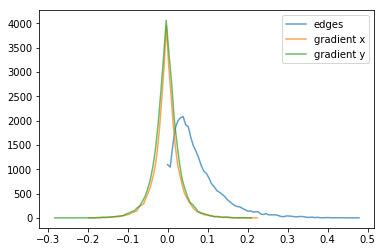

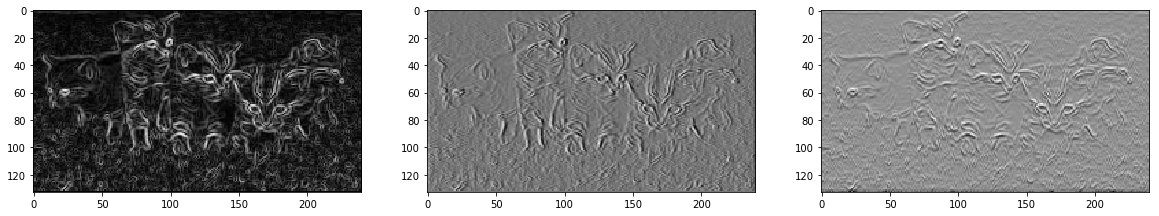

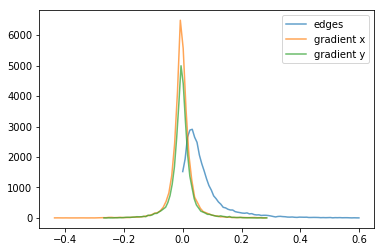

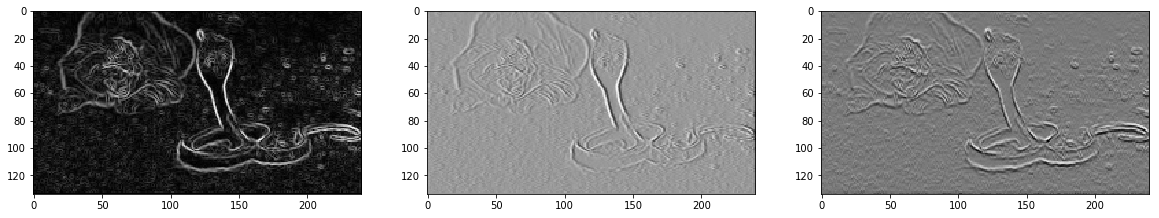

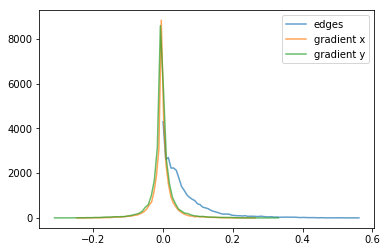

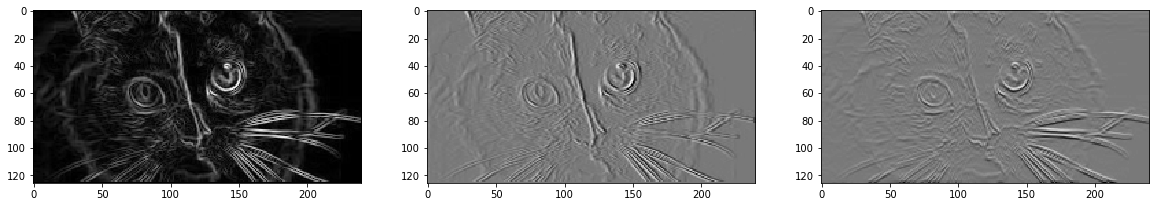

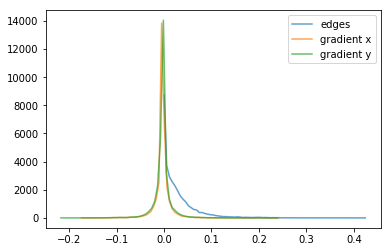

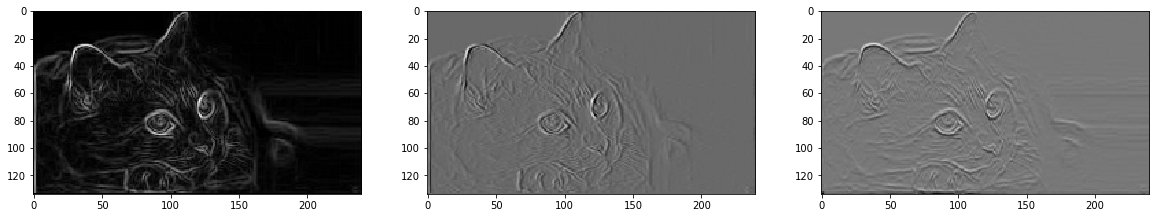

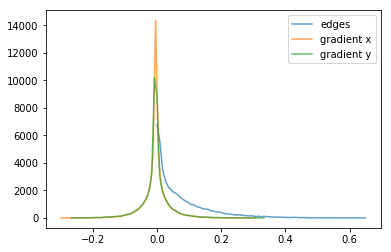

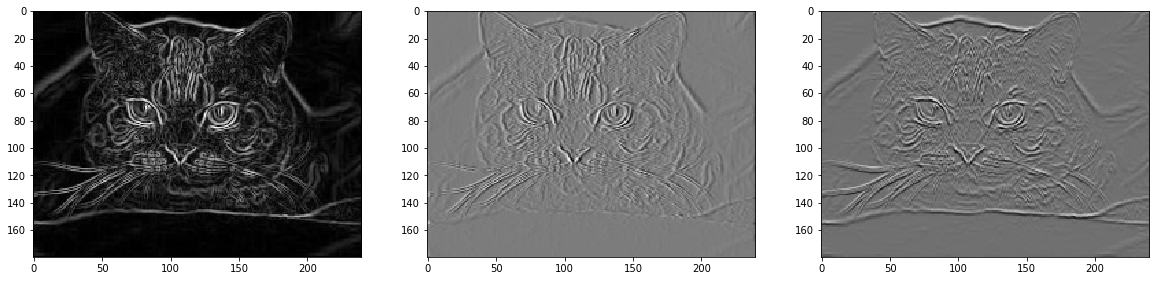

In [332]:
from skimage.filters import sobel

n_features = 75
features = np.ones(shape=(len(images), n_features*2)) # initialize feature matrix

for i, image in enumerate(images):
    edges = sobel(image.convert('HSV').getchannel('V'))
    hist, bins = np.histogram(edges, bins=n_features)
    grad_y, grad_x = np.gradient(edges)
    hist_x, bins_x = np.histogram(grad_x, bins=n_features)
    hist_y, bins_y = np.histogram(grad_y, bins=n_features)
    features[i] = np.append(hist_x, hist_y)                
    if i < 5:
        plt.figure()
        plt.plot(bins[:-1], hist, alpha=.7, label='edges') # use the gradients or magnitues?
        plt.plot(bins_x[:-1], hist_x, alpha=.7, label='gradient x')
        plt.plot(bins_y[:-1], hist_y, alpha=.7, label='gradient y')
        plt.legend()
        plt.show()
        plt.figure(figsize=(20, 5))
        plt.subplot(1,3,1)
        plt.imshow(edges, cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(grad_x, cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(grad_y, cmap='gray')

X = np.column_stack((X, features)) # add new features to feature matrix X

### Custom edge calculation

[5078. 3131. 4579. 2901. 2730. 4465. 2806. 4300.]


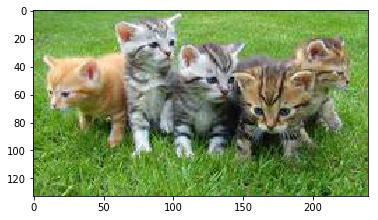

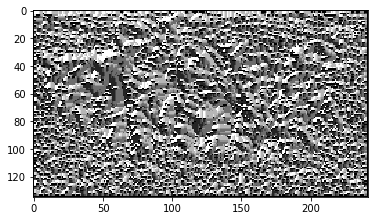

In [392]:
import math

n_features = 8 # one for each direction
features = np.ones(shape=(len(images), n_features)) # initialize feature matrix

for n, image in enumerate(images):
    grayscale = np.array(image.convert('L'))
    grayscale = np.pad(grayscale, 1, mode='constant') # surround with 0s to avoid out-of-bounds checks
    angles = np.zeros(grayscale.shape)
    magnitudes = np.zeros(grayscale.shape)
    dir_counts = np.zeros(n_features)
    for i in range(1, grayscale.shape[0] - 1):
        for j in range(1, grayscale.shape[1] - 1):
            mag = 0
            for ii in range(-1, 2):
                for jj in range(-1, 2):
                    if ii == jj == 0: next
                    if grayscale[i + ii, j + jj] > mag:
                        mag = grayscale[i + ii, j + jj]
                        mii = ii
                        mjj = jj
            ang = 0
            if (mii == -1):
                if   (mjj == -1): ang = 135; dir_counts[0]+=1
                elif (mjj == 0):  ang = 90;  dir_counts[1]+=1
                elif (mjj == 1):  ang = 45;  dir_counts[2]+=1
            elif (mii == 0):    
                if   (mjj == -1): ang = 180; dir_counts[3]+=1
                elif (mjj == 1):  ang = 0;   dir_counts[4]+=1

            elif (mii == 1):
                if   (mjj == -1): ang = 225; dir_counts[5]+=1
                elif (mjj == 0):  ang = 270; dir_counts[6]+=1
                elif (mjj == 1):  ang = 315; dir_counts[7]+=1
                           
            angles[i, j]= ang
            magnitudes[i, j] = mag
    features[n] = dir_counts
    if n < 1:
        print(dir_counts)
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.figure()
        plt.imshow(angles, cmap='gray')

X = np.column_stack((X, features)) # add new features to feature matrix X
    
        

## Wavelet Transformation

In [325]:
import pywt

for i, image in enumerate(images):
    img = np.array(image)
    coeffs = pywt.dwtn(img, 'haar')
    #cA, cD = pywt.dwt(img, 'db1')
    plt.figure()
    print(len(coeffs))
    break


8


[[1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 7.2300e+03 2.3290e+03 4.5370e+03 3.1450e+03
  2.4350e+03 8.5550e+03 3.0630e+03 5.6800e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 6.1240e+03 2.7770e+03 5.6540e+03 3.0010e+03
  2.7630e+03 4.7880e+03 2.0570e+03 3.7980e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.2199e+04 2.5260e+03 4.7930e+03 2.7560e+03
  2.6070e+03 5.1550e+03 2.2490e+03 4.9480e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.1112e+04 3.0280e+03 4.4970e+03 3.0010e+03
  2.0650e+03 6.5580e+03 2.3890e+03 4.4350e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.5103e+04 1.7170e+03 1.8760e+03 6.8340e+03
  1.0230e+03 8.1140e+03 1.1640e+03 1.5040e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.00

# K-means clustering

In [396]:
from sklearn.cluster import KMeans
import re, shutil

kmeans = KMeans(n_clusters=8, random_state=0).fit(X)

images_by_cluster = sorted(zip(images, kmeans.labels_), key=lambda x: x[1]) # create sorted list of (<image>, <cluster>) pairs

base_dir = 'c:/clustering/result/'
shutil.rmtree(base_dir)
for image, cluster in images_by_cluster: # save images in a directory per cluster
    cluster_dir = base_dir + str(cluster)
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir)
    image_name = cluster_dir + '/' + re.split("[/\\\]", image.filename)[-1]
    image.save(image_name, 'JPEG')


#kmeans.labels_
#kmeans.cluster_centers_


